IMPORTAÇÕES (Executar antes)

In [1]:
import math
import random
from random import randrange
from deap import creator, base, tools, algorithms
import numpy as np 
import pandas as pd
import seaborn as sns; 
import matplotlib.pyplot as plt

GA (Implementado de forma genérica/Necessário atualizar as variáveis globais)

In [161]:
#Atualizar antes da execução
n_clusters = 0
datasettestado =  ''
size = 0
NGEN= 50
dic_cluster = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

In [3]:
def distanciaEuclidiana(ponto1, ponto2):
    x1,y1 = ponto1
    x2,y2 = ponto2
    
    dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist

In [158]:
#Converte de binário para decimal
def converte_individuos(individual, k, tam):

    individuos = []
    c = 0
    
    for i in range(0,k*2):
        aux = ''        
        for j in range(c, tam+c):
            aux = aux + str(individual[j])            
        c +=tam
        aux = int(aux, 2)
        individuos.append(aux)    
    
    return individuos

In [130]:
def separa_clusters(dataset, individuos, k):    
    #iniciliza os clusters 
    clusters = []    
    j = 0
    
    for l in range(0,k):
        aux = []
        clusters.append(aux)

    #calcula a distância euclidiana para todos os pontos do dataset
    for item in dataset:
        c = []
        i = 0
        j = 0         
        for i in range(0,k):
            item2 = (individuos[j], individuos[j+1])
            c.append(distanciaEuclidiana(item, item2))
            j+=2
  
        #encontra a menor distância para adicionar o elemento ao cluster correto        
        indice = c.index(min(c))
        
        clusters[indice].append(item)
    #print(clusters)
    return clusters

In [30]:
def atualiza_centroides(individuos, k, clusters):
    
    novos_centroides = []
    j = 0
    
    for i in range(0, k):        
        aux = [individuos[j], individuos[j+1]]
        j += 2
        novos_centroides.append(aux)
        
        for aux in clusters[i]:
            x, y = aux            
            novos_centroides[i][0] += x
            novos_centroides[i][1] += y 
            
        novos_centroides[i][0] = novos_centroides[i][0]/(len(clusters[i])+1)
        
    return novos_centroides

In [142]:
#Função de avaliação individual de cada individuo
def evalOneMax(individual):
    
    #Faz a conversão para decimal
    individuos = converte_individuos(individual, n_clusters, size)
    
    #Fase 1: distancia euclidiana em função dos pontos do dadaset e definição dos clusters 
    clusters = separa_clusters(datasettestado, individuos, n_clusters)
    
    #Fase 2: atualização do centroides dos clusters    
    novos_centroides = atualiza_centroides(individuos, n_clusters, clusters)
    
    #Apartir dos novos centroides as distâncias são recalculadas, gerando a função de avaliação
    m = 0
    j = 0
    c = 0

    for lista in clusters:        
        for item in lista:            
            m += distanciaEuclidiana(item, (novos_centroides[c][j], novos_centroides[c][j+1]))            
        c += 1
        
    if m != 0:
        f = 1/m
    else: 
        f = 0

    return f,

In [163]:
def GA():

    ## creating fitness values and weights
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()

    # Each gene (cluster) is assigned 1 or 0
    toolbox.register("attr_bool", random.randint, 0, 1)
    # total genes in a chromosome(individual) = set to 100 (the more genes the better result)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=size*2*n_clusters) 
    # creating population from all the chromosomes
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)


    # evaluation of each chromosome
    toolbox.register("evaluate", evalOneMax)
    # mating / cross-over of two chromosomes
    toolbox.register("mate", tools.cxTwoPoint)
    # mutation with mutation probability = 0.05
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.5)
    # tournament selection with size =3
    toolbox.register("select", tools.selTournament, tournsize=3)

    # creating total population of size 300
    population = toolbox.population(n=8)

    for gen in range(NGEN):
        offspring = algorithms.varAnd(population, toolbox, cxpb=0.8, mutpb=0.5)
        fits = toolbox.map(toolbox.evaluate, offspring)
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit
        population = toolbox.select(offspring, k=len(population))

    # selecting top 3 best chromosomes    
    top10 = tools.selBest(population, k=10)
    return top10

PLOT - Genérico

In [9]:
def gera_pontos(cluster, id_cluster):
    x_list = []
    y_list = []
    tipo_cluster = []
    
    for i in cluster:
        x, y = i
        x_list.append(x)
        y_list.append(y)
        tipo_cluster.append(id_cluster)
        
    return x_list, y_list, tipo_cluster

In [143]:
def gera_dataframe(dataset, k, res):
    x_list = []
    y_list = []
    id_cluster = []
    c = 0

    centroides = converte_individuos(res, k, size)
    clusters = separa_clusters(dataset, centroides, k)

    for item in clusters:
        x, y, idi_cluster = gera_pontos(item, dic_cluster[c])
        x_list = x_list + x
        y_list = y_list + y
        id_cluster =  id_cluster + idi_cluster        
        c +=1

    data = {'x': x_list,
            'y': y_list,
            'Cluster': id_cluster}

    # Create DataFrame
    df = pd.DataFrame(data)

    return df    

In [73]:
def gera_plot(dataset, k, res):
    df = gera_dataframe(dataset, k, res)
    tips = sns.load_dataset("tips")
    ax = sns.scatterplot(x="x", y="y",hue="Cluster", data=df)

Experiment 1

In [12]:
random.seed(9001) #Para gerar sempre a mesma sequência

# Criação de 3 datasets com 10 pontos gerados aleatoriamente no R²
dataset1 = [(randrange(127), randrange(127)) for _ in range(10)]
dataset2 = [(randrange(127), randrange(127)) for _ in range(10)]
dataset3 = [(randrange(127), randrange(127)) for _ in range(10)]          

/home/karine/anaconda3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/karine/anaconda3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


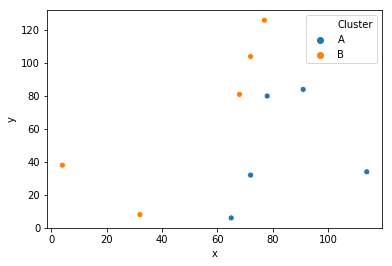

In [144]:
#Dataset 1
n_clusters = 2
datasettestado =  dataset1
size = 7
NGEN=40

top10 = GA()
gera_plot(datasettestado, n_clusters, top10[0])

/home/karine/anaconda3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/karine/anaconda3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


[[(37, 106), (9, 69), (56, 93), (50, 111)], [(97, 99), (125, 45), (75, 65), (98, 28), (77, 58), (94, 113)]]


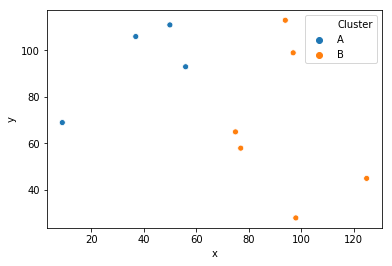

In [137]:
#Dataset 2
n_clusters = 2
datasettestado =  dataset2
size = 7
NGEN=40

top10 = GA()
gera_plot(datasettestado, n_clusters, top10[0])

/home/karine/anaconda3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/karine/anaconda3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


[[(31, 62), (39, 28), (20, 50), (66, 35), (22, 38)], [(102, 28), (112, 16), (81, 48), (67, 104), (63, 108)]]


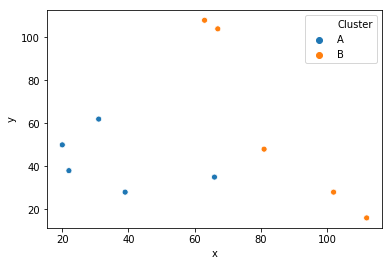

In [138]:
#Dataset 3
n_clusters = 2
datasettestado =  dataset3
size = 7
NGEN=40

top10 = GA()
gera_plot(datasettestado, n_clusters, top10[0])

Experiment 2

In [165]:
random.seed(5064) #Para gerar sempre a mesma sequência


# Criação de 5 datasets com 50 pontos gerados aleatoriamente no R²
classe1 = [(randrange(0,500), randrange(0,500)) for _ in range(10)]
classe2 = [(randrange(1000,1500), randrange(1000,1500)) for _ in range(10)]
classe3 = [(randrange(2000,2500), randrange(2000,2500)) for _ in range(10)]
classe4 = [(randrange(3000,3500), randrange(3000,3500)) for _ in range(10)]

/home/karine/anaconda3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/karine/anaconda3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


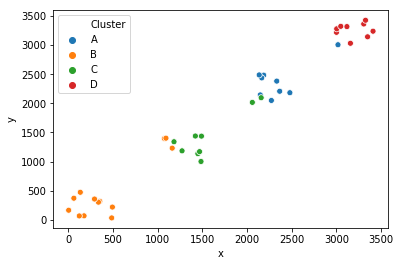

In [166]:
#Dataset 1
n_clusters = 4
datasettestado = classe1 + classe2 + classe3 + classe4
size = 12
NGEN = 10000

top10 = GA()
gera_plot(datasettestado, n_clusters, top10[0])